In [1]:
# Basic imports for file handling, warnings, and garbage collection
import os
import itertools
import warnings
import gc
warnings.filterwarnings('ignore')  # Ignoring warnings for cleaner output

# Importing data handling and machine learning libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from skimage import io  # Image handling
from skimage.transform import resize  # Image resizing

# TensorFlow and Keras imports for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.applications import NASNetMobile, InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, concatenate, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Specific pre-processing for different model architectures
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet

# Visualization and augmentation libraries
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
sns.set_style('darkgrid')
import dataframe_image as dfi  # For exporting pandas DataFrame as an image

# Importing visualization tools for model analysis
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Augmentation library and OpenCV for image manipulation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch
import cv2
from PIL import Image

np.bool = np.bool_  # Updating numpy boolean type

# Printing TensorFlow version and checking for GPU availability
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.13.0
[]


In [2]:
# Accessing and configuring GPUs for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Setting memory growth for each GPU to avoid occupying full memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Creating logical GPUs for efficient memory usage
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:  # Handling potential runtime errors
        print(e)


In [3]:
def load_dataset(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get top-level folders (lung and colon)
    for category in os.listdir(data_dir):
        if category == '.DS_Store':
            continue  # Ignore .DS_Store
        cat_path = os.path.join(data_dir, category)

        # Get condition folders within each category
        for condition in os.listdir(cat_path):
            if condition == '.DS_Store':
                continue  # Ignore .DS_Store
            condition_path = os.path.join(cat_path, condition)

            # Get files in each condition
            for filename in os.listdir(condition_path):
                if filename == '.DS_Store':
                    continue  # Ignore .DS_Store
                filepath = os.path.join(condition_path, filename)

                filepaths.append(filepath)
                labels.append(condition)

    # Concatenate data paths with labels into one DataFrame
    df = pd.concat([pd.Series(filepaths, name='filepaths'), pd.Series(labels, name='labels')], axis=1)

    return df

def change_label_names(df, column_name):
    # Updated to reflect two-level folder structure
    index = {
        'lung_aca': 'Lung_adenocarcinoma',
        'lung_n': 'Lung_benign_tissue',
        'lung_scc': 'Lung_squamous_cell_carcinoma',
        'colon_n': 'Colon_benign_tissue',
        'colon_aca': 'Colon_adenocarcinoma'
    }

    df[column_name] = df[column_name].replace(index)
    return df

In [4]:
data_dir = './lung_colon_image_set'
df = load_dataset(data_dir)

change_label_names(df, 'labels')

dfi.export(df.head(), 'data_sample.png')

df

,filepaths,labels
0,./lung_colon_image_set/lung_image_sets/lung_ac...,Lung_adenocarcinoma
1,./lung_colon_image_set/lung_image_sets/lung_ac...,Lung_adenocarcinoma
2,./lung_colon_image_set/lung_image_sets/lung_ac...,Lung_adenocarcinoma
3,./lung_colon_image_set/lung_image_sets/lung_ac...,Lung_adenocarcinoma
4,./lung_colon_image_set/lung_image_sets/lung_ac...,Lung_adenocarcinoma
...,...,...
24995,./lung_colon_image_set/colon_image_sets/colon_...,Colon_adenocarcinoma
24996,./lung_colon_image_set/colon_image_sets/colon_...,Colon_adenocarcinoma
24997,./lung_colon_image_set/colon_image_sets/colon_...,Colon_adenocarcinoma
24998,./lung_colon_image_set/colon_image_sets/colon_...,Colon_adenocarcinoma


In [5]:
def plot_data_balance(data_balance, labels=None, colors=None, figsize=(8, 8), title="Target Distribution in the Dataset"):
    # Custom function to format the percentage and absolute value in the pie chart
    def custom_autopct(pct):
        total = sum(data_balance)  # Summing up all data points to calculate percentages
        val = int(round(pct*total/100.0))  # Calculating the absolute number of data points for the given percentage
        return "{:.1f}%\n({:d})".format(pct, val)  # Formatting string to show both percentage and absolute value

    plt.figure(figsize=figsize)  # Setting the size of the figure
    # Creating a pie chart:
    # data_balance - contains the data to plot
    # labels - labels for each section in the pie chart, defaults to the index of data_balance if not provided
    # autopct - function to format the text to be displayed on the slices
    # colors - color for each section in the pie chart
    plt.pie(data_balance, labels=labels if labels else data_balance.index, autopct=custom_autopct, colors=colors)
    plt.title(title)  # Setting the title of the chart
    plt.axis("equal")  # Ensuring the pie chart is circular
    plt.show()  # Displaying the plot


Index(['Lung_adenocarcinoma', 'Lung_benign_tissue',
       'Lung_squamous_cell_carcinoma', 'Colon_benign_tissue',
       'Colon_adenocarcinoma'],
      dtype='object', name='labels')


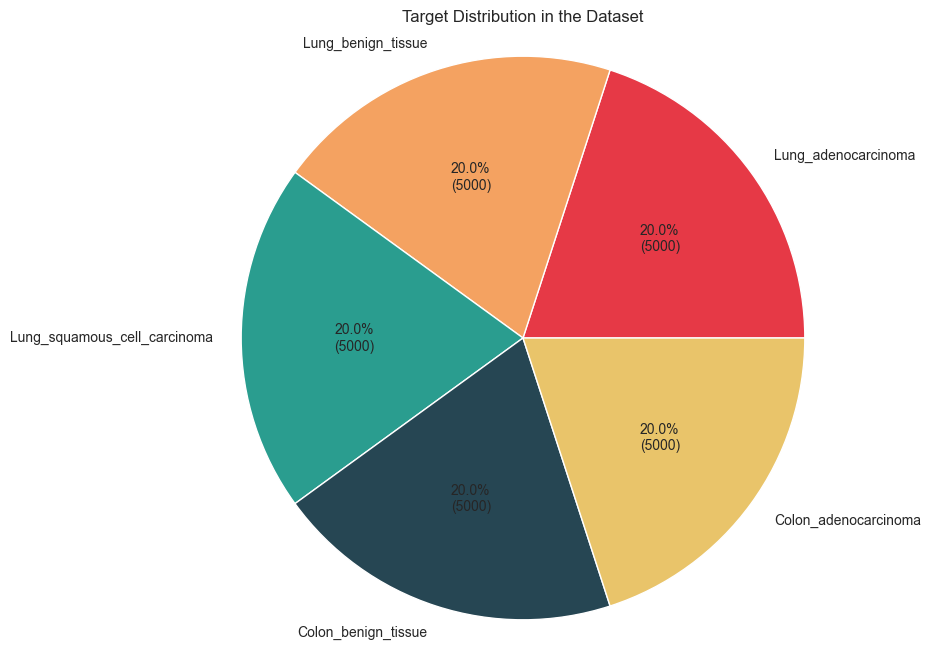

In [6]:
# Calculate the distribution of the labels
data_balance = df['labels'].value_counts()
print(data_balance.index)
colors = ["#E63946", "#F4A261", "#2A9D8F", "#264653", "#E9C46A"]
plot_data_balance(data_balance, colors=colors)


In [7]:
# Splitting data into 80% train and 20% temporary data (which will be split into validation and test sets)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Splitting the temporary data into validation and test sets (50% each of the temp data)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# Display the sizes of each dataset to verify
print(f"Training Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(valid_df)}")
print(f"Test Set Size: {len(test_df)}")

Training Set Size: 20000
Validation Set Size: 2500
Test Set Size: 2500


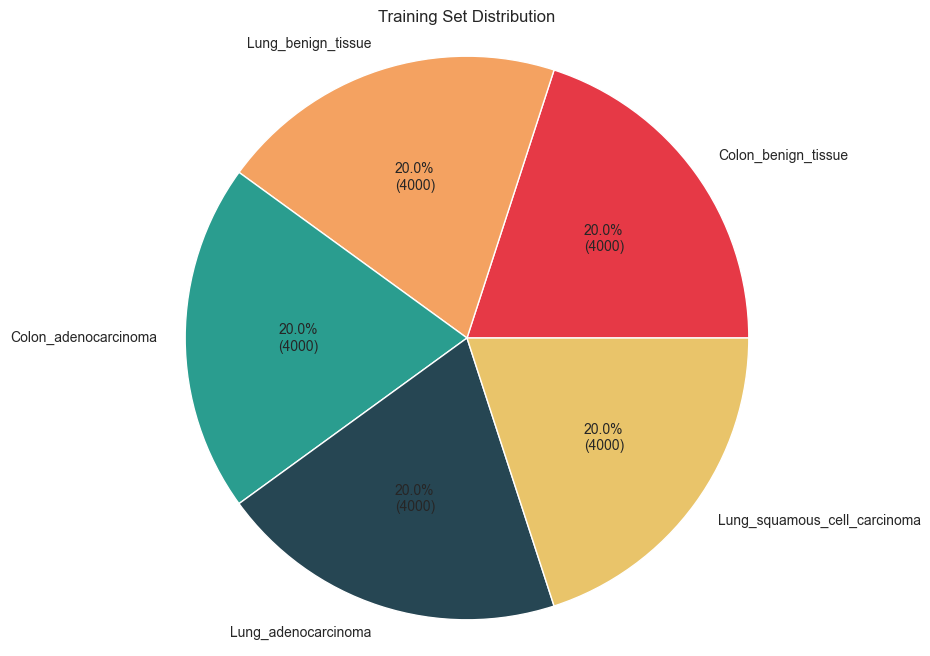

In [8]:
# Calculate the distribution of the labels
train_data_balance = train_df['labels'].value_counts()

plot_data_balance(train_data_balance, colors=colors, title="Training Set Distribution")


In [9]:
class HistopathologicCancerDataset(Sequence):
    def __init__(self, dataframe, batch_size=64, num_augmentations=64, input_shape=(224, 224), n_classes=5, num_channels=3, shuffle=True, augmentation=None):
        # Constructor to initialize the dataset object
        # dataframe: The pandas DataFrame containing image paths and labels
        # batch_size: Number of samples per batch
        # num_augmentations: Number of augmented images to generate from each original image
        # input_shape: Shape of input images (height, width)
        # n_classes: Number of classes in the dataset
        # num_channels: Number of color channels in the image (e.g., 3 for RGB)
        # shuffle: Whether to shuffle the dataset at the end of each epoch
        # augmentation: Function to apply data augmentation

        self.dataframe = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.shuffle = shuffle
        self.augmentations = num_augmentations
        self.augmentation = augmentation
        self.label_mapping = {'Lung_benign_tissue': 0, 'Lung_adenocarcinoma': 1, 'Lung_squamous_cell_carcinoma': 2, 'Colon_adenocarcinoma': 3, 'Colon_benign_tissue': 4}
        self.original_images = []  # List to store original (non-augmented) images
        self.on_epoch_end()  # Prepare the dataset for training

    def __len__(self):
        # Returns the number of batches in the dataset
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        # Retrieve a batch at the given index
        # index: Index of the batch to retrieve

        # Calculate the indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]
        # Generate data for this batch
        X_augmented, y = self.__data_generation(batch_df)
        return X_augmented, y

    def on_epoch_end(self):
        # Actions to perform at the end of each epoch
        # Reset indexes and shuffle them if required

        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        self.original_images = []  # Clearing the original images list

    def __data_generation(self, df):
        # Private method to generate data for a batch
        # df: DataFrame containing the batch's data

        # Initialize arrays for storing images and labels
        X_augmented = np.empty((self.batch_size * self.augmentations, *self.input_shape, self.num_channels))
        X_original = np.empty((self.batch_size, *self.input_shape, self.num_channels))
        y = np.empty((self.batch_size * self.augmentations), dtype=int)

        for i, (_, row) in enumerate(df.iterrows()):
            # Reading and processing each image
            original_image = cv2.imread(row.filepaths)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            original_image = cv2.resize(original_image, self.input_shape[:2])
            # Normalizing and storing the original image
            X_original[i,] = original_image / 255.0
            self.original_images.append(original_image / 255.0)  # Add to class-wide list
            label = self.label_mapping[row.labels]  # Mapping label names to integers

            # Generating augmented images if augmentation is specified
            for j in range(self.augmentations):
                if self.augmentation is not None:
                    augmented_image = self.augmentation(original_image)
                    X_augmented[i*self.augmentations+j,] = augmented_image / 255.0
                    y[i*self.augmentations+j] = label

        # Return the batch of augmented images and their one-hot encoded labels
        return X_augmented, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

    def get_original_images(self, batch_index):
        # Method to retrieve original images for a given batch
        # batch_index: Index of the batch

        start = batch_index * self.batch_size
        end = (batch_index + 1) * self.batch_size
        return self.original_images[start:end]


In [10]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # Horizontally flip 50% of all images. Consider for lung, but be cautious with colon images.
    # Slight rotation and translations to simulate patient movement
    sometimes(iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # slight scaling to simulate zoom variations
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # minor translations
        rotate=(-5, 5), # rotate by -5 to +5 degrees to simulate patient positioning
        order=[0, 1], # nearest neighbour or bilinear interpolation
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes
    )),
    # Brightness and contrast adjustments
    sometimes(iaa.Multiply((0.8, 1.2))), # adjust brightness, simulate exposure variations
    sometimes(iaa.LinearContrast((0.9, 1.1))), # adjust contrast
    # Elastic transformations to simulate tissue flexibility, applied very mildly
    sometimes(iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25)),
    # Color augmentations
    sometimes(iaa.AddToHueAndSaturation((-20, 20))), # Randomly change hue and saturation
    sometimes(iaa.GammaContrast((0.9, 1.1))), # Adjust gamma for simulated brightness variability
    sometimes(iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True)), # Multiply H and S channel separately
    # Gaussian Blur to simulate slight focus variations
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
    # Additive Gaussian Noise to simulate sensor noise
    sometimes(iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))),
    # In case of over/under staining
    sometimes(iaa.KMeansColorQuantization(n_colors=(4, 16))),
])

apply_augmentation = lambda image: seq(image=image)


In [11]:
# Define the input image size for Inception model
img_size_inception = (299, 299)
batch_size = 64  # Define the batch size

# Creating training data generator using the HistopathologicCancerDataset class
train_datagen_inception = HistopathologicCancerDataset(
    dataframe=train_df,  # The dataframe containing training data
    batch_size=batch_size,  # Number of samples per batch
    input_shape=img_size_inception,  # Image size expected by the Inception model
    n_classes=5,  # Number of classes in the dataset
    augmentation=apply_augmentation  # Function to apply data augmentation to training data
)

# Creating validation data generator
# Note: Data augmentation is typically not applied to validation data
valid_datagen_inception = HistopathologicCancerDataset(
    dataframe=valid_df,  # The dataframe containing validation data
    batch_size=batch_size,  # Same batch size as training data
    input_shape=img_size_inception,  # Same image size as training data
    n_classes=5  # Same number of classes as in training data
)

# Creating test data generator
test_datagen_inception = HistopathologicCancerDataset(
    dataframe=test_df,  # The dataframe containing test data
    batch_size=batch_size,  # Same batch size as training data
    input_shape=img_size_inception,  # Same image size as training data
    n_classes=5,  # Same number of classes as in training data
    shuffle=False  # No need to shuffle test data
)


In [12]:
#image_size = (224, 224)
img_size_nasnet = (224, 224) 

train_datagen_nasnet = HistopathologicCancerDataset(
    dataframe=train_df,
    batch_size=batch_size,
    input_shape=img_size_nasnet,  
    n_classes=5,
    augmentation=apply_augmentation  
)
valid_datagen_nasnet = HistopathologicCancerDataset(
    dataframe=valid_df,
    batch_size=batch_size,
    input_shape=img_size_nasnet,
    n_classes=5,
    augmentation=apply_augmentation
)
# Test data generator
test_datagen_nasnet = HistopathologicCancerDataset(
   dataframe=test_df,
    batch_size=batch_size,
    input_shape=img_size_nasnet,
    n_classes=5,
    shuffle=False    
)

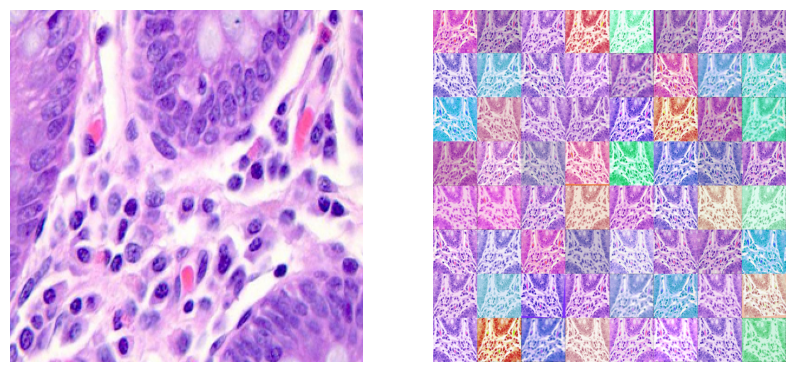

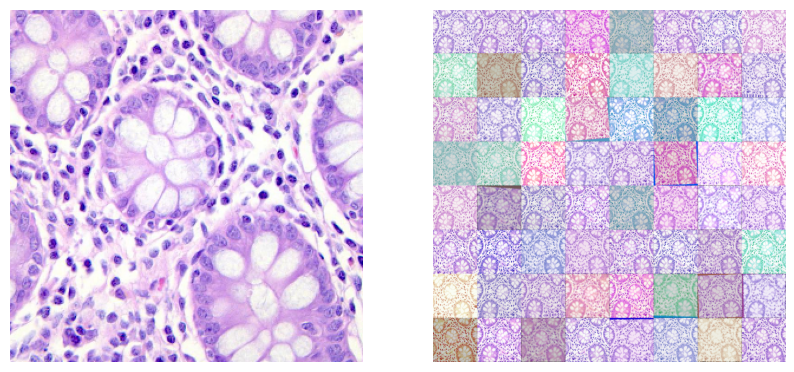

In [13]:
def images_to_grid(images):
    return np.vstack([np.hstack(images[i*8:(i+1)*8]) for i in range(8)])

def plot_image_and_augmentations(original, augmentations):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    # Display the original image
    axs[0].imshow(original)
    axs[0].axis('off')

    # Display all augmented images as a grid
    axs[1].imshow(images_to_grid(augmentations))
    axs[1].axis('off')

    plt.show()

def plot_batch_images(datagen, batch_index=0):
    augmented_images, _ = datagen.__getitem__(batch_index)
    original_images = datagen.get_original_images(batch_index)

    # Loop through the first two original images
    for i in range(2):  # Adjusted to process only the first two images
        original = original_images[i]  # Select the original image
        augmentations = augmented_images[i * datagen.augmentations:(i + 1) * datagen.augmentations]  # Select the corresponding augmented images

        plot_image_and_augmentations(original, augmentations)  # Plot the original and augmented images


plot_batch_images(train_datagen_inception, 0)

In [14]:
def model_performance(history):
    # Define needed variables from history
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = [i + 1 for i in range(len(tr_acc))]

    # Find the epoch with the best validation loss (minimum)
    best_epoch_loss = val_loss.index(min(val_loss)) + 1
    # Alternatively, find the epoch with the best validation accuracy (maximum)
    best_epoch_acc = val_acc.index(max(val_acc)) + 1

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plot for loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label=f'Training Loss')
    plt.plot(epochs, val_loss, 'g', label=f'Validation Loss - Best Epoch: {best_epoch_loss}')
    plt.scatter(best_epoch_loss, min(val_loss), color='blue', label=f'Best Epoch Loss: {min(val_loss):.4f}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label=f'Validation Accuracy - Best Epoch: {best_epoch_acc}')
    plt.scatter(best_epoch_acc, max(val_acc), color='blue', label=f'Best Epoch Accuracy: {max(val_acc):.4f}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def model_evaluation(model, train_gen, valid_gen, test_gen, verbose=1):
    # Evaluate the model on the datasets
    train_score = model.evaluate(train_gen, verbose=verbose)
    valid_score = model.evaluate(valid_gen, verbose=verbose)
    test_score = model.evaluate(test_gen, verbose=verbose)

    # Assuming model.metrics_names is available and aligns with the scores
    metrics = model.metrics_names

    # Display training scores
    print("Training Results:")
    for metric, score in zip(metrics, train_score):
        print(f"{metric.capitalize()}: {score:.4f}")
    print('-' * 30)

    # Display validation scores
    print("Validation Results:")
    for metric, score in zip(metrics, valid_score):
        print(f"{metric.capitalize()}: {score:.4f}")
    print('-' * 30)

    # Display test scores
    print("Test Results:")
    for metric, score in zip(metrics, test_score):
        print(f"{metric.capitalize()}: {score:.4f}")

def get_pred(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    # Optional: Return the raw probabilities alongside class predictions
    return y_pred, preds
  
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Get class indices and names
    classes = list(class_names.keys())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Threshold for text color contrast
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_and_calculate_auroc(y_true, y_pred_probs, class_names):
 # Ensure y_true is a numpy array
    y_true = np.array(y_true)

    # Derive the number of classes from class_names list
    num_classes = len(class_names)

    # Convert y_true to one-hot encoding if it's not already
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
        y_true_one_hot = np.eye(num_classes)[y_true.reshape(-1)]
    else:
        y_true_one_hot = y_true

    # Compute ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for each class in a separate figure
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {class_names[i]}')
        plt.legend(loc="lower right")
        plt.show()

        # Print the AUROC score for the class
        print(f'AUROC for {class_names[i]}: {roc_auc:.2f}')

def generate_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def format_memory(size_bytes):
    size_mb = size_bytes * 4 / (1024 * 1024)  # Assuming 4 bytes per parameter
    return f"{size_mb:.2f} MB"

def simplified_model_summary(model, custom_layers_details, filename='model_summary.png'):
    import matplotlib.pyplot as plt
    from matplotlib.table import Table

    # Calculate parameter stats
    total_params = model.count_params()
    trainable_count = sum(np.prod(v.shape.as_list()) for v in model.trainable_weights)
    non_trainable_count = total_params - trainable_count

    # Preparing summary data
    summary_data = [
        ["Layer Type", "Param #"],
        *[[detail['layer_type'], detail['params']] for detail in custom_layers_details],
        ["Total params", f"{total_params:,}"],
        ["Trainable params", f"{trainable_count:,}"],
        ["Non-trainable params", f"{non_trainable_count:,}"]
    ]

    # Plotting the DataFrame as a table and saving to PNG
    fig, ax = plt.subplots(figsize=(8, len(summary_data) * 0.3 + 1))  # Adjust figure size
    ax.axis('off')
    table = Table(ax, bbox=[0, 0, 1, 1])

    for i, (label, value) in enumerate(summary_data):
        table.add_cell(i, 0, width=0.6, height=0.1, text=label, loc='center')
        table.add_cell(i, 1, width=0.4, height=0.1, text=value, loc='center')

    ax.add_table(table)
    plt.savefig(filename)
    plt.close()
    

def visualize_images(image_array, selected_labels):
    # Assuming image_array is of shape (5, height, width, channels)
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed
    
    for i, ax in enumerate(axes):
        ax.imshow(image_array[i])
        ax.title.set_text(selected_labels[i])
        ax.axis('off')  # Hide axes ticks
    
    plt.show()


In [15]:
# Callbacks
# Early Stopping to halt the training after no improvement
early_stopping_inception = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Model Checkpoint to save the best model
model_checkpoint_inception = ModelCheckpoint(
    'best_model_inception.keras', monitor='val_loss', save_best_only=True, verbose=1
)

# Setting up the callback
reduce_lr_inception = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

In [16]:
# Load InceptionV3 as the base model, without the top classification layer
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False)

# Assuming 'base_model' is your pre-trained base model
x = base_model_inceptionv3.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Batch Normalization
x = BatchNormalization()(x)

# Add a fully-connected layer with Batch Normalization and experiment with the unit number
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)

# Add a dropout layer to prevent overfitting
x = Dropout(0.5)(x)  # A rate of 0.5 is a good starting point

# Add a final softmax layer for classification
predictions = Dense(5, activation='softmax')(x)

# This is the model we will train
InceptionV3_model = Model(inputs=base_model_inceptionv3.input, outputs=predictions)



# First: train only the top layers (which were randomly initialized)
# i.e., freeze all convolutional InceptionV3 layers
for layer in base_model_inceptionv3.layers:
    layer.trainable = False

# Compile the model (should be done *after* setting layers to non-trainable)
InceptionV3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Get the model summary
plot_model(InceptionV3_model, to_file='InceptionV3Model_architecture.png', show_shapes=True, show_layer_names=True)
InceptionV3_model.summary()
custom_layers_details = [
    {'layer_type': 'GlobalAveragePooling2D', 'params': '0'},
    {'layer_type': 'BatchNormalization', 'params': '8,192'},
    {'layer_type': 'Dense (1024 units, relu)', 'params': '2,098,176'},
    {'layer_type': 'BatchNormalization', 'params': '4,096'},
    {'layer_type': 'Dropout (0.5)', 'params': '0'},
    {'layer_type': 'Dense (5 units, softmax)', 'params': '5,125'}
]
simplified_model_summary(InceptionV3_model, custom_layers_details, filename='InceptionV3Model_summary.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                            

In [ ]:
# Assuming you have already set up your data generators: train_gen, valid_gen
epochs = 30

# Fit the model on the data provided by the train_gen generator
InceptionV3_history = InceptionV3_model.fit(
    train_datagen_inception,
    epochs=epochs,
    validation_data=valid_datagen_inception,
    callbacks=[early_stopping_inception, model_checkpoint_inception, reduce_lr_inception]
)

Epoch 1/30


In [ ]:
model_performance(InceptionV3_history)

In [ ]:
model_evaluation(InceptionV3_model, train_datagen_inception, valid_datagen_inception, test_datagen_inception)

In [ ]:
y_pred_inceptionv3, preds_inceptionv3 = get_pred(InceptionV3_model, test_datagen_inception)

In [ ]:
y_true = test_df['labels'].values
y_true = np.array([test_datagen_inception.label_mapping[label] for label in y_true])

In [ ]:
inceptionV3_report = generate_classification_report(y_true, y_pred_inceptionv3, test_datagen_inception.label_mapping)
dfi.export(inceptionV3_report, 'inceptionV3_classification_report.png')
inceptionV3_report

In [ ]:
plot_confusion_matrix(y_true, y_pred_inceptionv3, test_datagen_inception.label_mapping)

In [ ]:
plot_and_calculate_auroc(y_true, preds_inceptionv3, list(train_datagen_inception.label_mapping))

In [ ]:
# Callbacks
# Early Stopping to halt the training after no improvement
early_stopping_nasnet = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Model Checkpoint to save the best model
model_checkpoint_nastnet = ModelCheckpoint(
    'best_model_nastnet.keras', monitor='val_loss', save_best_only=True, verbose=1
)

# Setting up the callback
reduce_lr_nasnet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

In [ ]:
base_NasNetMobile_model = NASNetMobile(weights='imagenet', include_top=False)

# Freeze all the layers in the base model to prevent them from being updated during the first phase of training
for layer in base_NasNetMobile_model.layers:
    layer.trainable = False

# Add new layers on top of the model
x = base_NasNetMobile_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# This is the model we will train
NasNetMobile_model = Model(inputs=base_NasNetMobile_model.input, outputs=predictions)

# Compile the model
NasNetMobile_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

custom_layers_details = [
    {'layer_type': 'GlobalAveragePooling2D', 'params': '0'},
    {'layer_type': 'BatchNormalization', 'params': '4,224'},
    {'layer_type': 'Dense (1024 units, relu)', 'params': '1,082,368'},
    {'layer_type': 'BatchNormalization', 'params': '4,096'},
    {'layer_type': 'Dropout (0.5)', 'params': '0'},
    {'layer_type': 'Dense (5 units, softmax)', 'params': '5,125'}
]
# Print the model summary
NasNetMobile_model.summary()
plot_model(NasNetMobile_model, to_file='NasNetMobileModel_architecture.png', show_shapes=True, show_layer_names=True)
simplified_model_summary(NasNetMobile_model, custom_layers_details, filename='NasNetMobile_summary.png')

In [ ]:
# Assuming you have train_gen and valid_gen set up correctly
epochs = 30

history_nasnet = NasNetMobile_model.fit(
    train_datagen_nasnet,
    epochs=epochs,
    validation_data=valid_datagen_nasnet,
    callbacks=[early_stopping_nasnet, model_checkpoint_nastnet, reduce_lr_nasnet]
)

In [ ]:
model_performance(history_nasnet)

In [ ]:
model_evaluation(NasNetMobile_model, train_datagen_nasnet, valid_datagen_nasnet, test_datagen_nasnet)

In [ ]:
y_pred_nasnet, preds_nasnet = get_pred(NasNetMobile_model, test_datagen_nasnet)

In [ ]:
nasnet_report = generate_classification_report(y_true, y_pred_nasnet, test_datagen_nasnet.label_mapping)
dfi.export(nasnet_report, 'nasnet_classification_report.png')
nasnet_report

In [ ]:
plot_confusion_matrix(y_true, y_pred_nasnet, test_datagen_nasnet.label_mapping)

In [ ]:
plot_and_calculate_auroc(y_true, preds_nasnet, list(train_datagen_nasnet.label_mapping))